# Loan eligblity prediction

### Onjective
When a customer applies for a loan at our company, we use statistical models to determine whether or not to grant the loan based on the likelihood of the loan being repaid. The factors involved in determining this likelihood are complex, and extensive statistical analysis and modelling are required to predict the outcome for each individual case.
* **
#### Approch 
- Language : Python
- Libraries : Scikit-learn, H2O, pandas, numpy, flask, Seaborn, Matplotlib
- Containerization : Docker


In [3]:
pip install h2o

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install impyute

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import impyute as impy
import h2o

In [6]:
#importing sklearn libraries
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [7]:
#importing h2o libraries
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

In [8]:
#reading the dataset
loans = pd.read_csv("/kaggle/input/direct-working/LoansTrainingSetV2.csv",low_memory = False).drop_duplicates()\
        .sort_values(by='Loan ID').reset_index(drop=True)

In [9]:
loans.shape

(98582, 19)

In [10]:
loans.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Loan Given,11731,Short Term,746.0,4 years,Rent,50025.0,Debt Consolidation,355.18,11.5,NaN,12,0,17391,37081,0.0,0.0
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,Loan Refused,24613,Long Term,NaN,6 years,Rent,NaN,Business Loan,542.29,17.6,73.0,7,0,14123,16954,0.0,0.0
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,Loan Given,99999999,Short Term,742.0,3 years,Home Mortgage,64760.0,Debt Consolidation,582.84,26.8,NaN,11,0,8880,22711,0.0,0.0
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,Loan Given,11863,Short Term,734.0,10+ years,Own Home,69202.0,Debt Consolidation,859.26,30.3,NaN,7,0,9959,16995,0.0,0.0
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719,Short Term,724.0,1 year,Own Home,34297.0,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0


## EDA and Feature engineering
- We are considering "Loan status" as the target variable

In [11]:
#checking the value counts in target variable
loans['Loan Status'].value_counts()

Loan Given      73411
Loan Refused    25171
Name: Loan Status, dtype: int64

count    9.858200e+04
mean     1.293347e+07
std      3.353892e+07
min      4.910000e+02
25%      8.194000e+03
50%      1.426000e+04
75%      2.420200e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64
34773.0


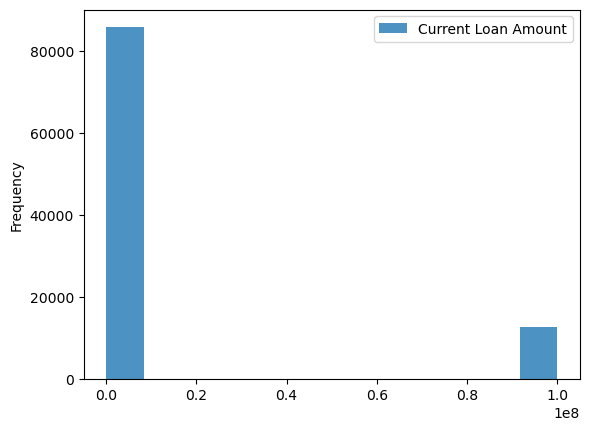

In [12]:
print(loans['Current Loan Amount'].describe())
print(np.quantile(loans['Current Loan Amount'], 0.85))
loans[['Current Loan Amount']].plot.hist(bins=12, alpha=0.8)

loan_amount_threshold = loans['Current Loan Amount'].max() / 2.0

- Since, the loan amount has exterme values we are replacing it with 'NaN'

In [13]:
loans['Current Loan Amount'] = np.where(loans['Current Loan Amount'] 
                                       > loan_amount_threshold, np.nan, loans['Current Loan Amount'])

- For the loanID coloumn there are not unique values, since there are lot of null columns in annual income and credit score
- Solution: Merging by using max aggegrate function

In [14]:
loans['Loan ID'].unique().shape

(88908,)

In [15]:
loans.groupby(["Loan ID", "Loan Status"]).filter(lambda x: x['Customer ID'].count() > 1).head(10)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719.0,Short Term,724.0,1 year,Own Home,34297.0,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0
5,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,13719.0,Short Term,NaN,1 year,Own Home,NaN,Home Improvements,777.38,13.6,2.0,12,0,6720,53335,0.0,0.0
8,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433.0,Short Term,716.0,10+ years,Home Mortgage,108735.0,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563,0.0,0.0
9,00069ff1-a877-4d35-81be-7cd359b99956,ee3c27f2-766a-499c-9a96-d17c4d2faa16,Loan Given,1433.0,Short Term,NaN,10+ years,Home Mortgage,NaN,Home Improvements,2627.76,15.1,5.0,22,0,27706,49563,0.0,0.0
22,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Loan Given,34185.0,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,1881.29,25.9,NaN,20,0,37507,50961,0.0,0.0
23,000dbdf1-3926-4676-bb4f-fe40c242a46e,5165c688-1669-43e9-88b5-db212c72655c,Loan Given,NaN,Long Term,717.0,3 years,Home Mortgage,88880.0,Debt Consolidation,1881.29,25.9,NaN,20,0,37507,50961,0.0,0.0
24,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Loan Given,21075.0,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,2204.13,18.0,NaN,22,0,21135,34366,0.0,0.0
25,000ea0cb-8d0e-4284-b8c8-444ffbbe4caf,db069b01-22c0-4b77-8b0a-b5704a0fd451,Loan Given,NaN,Short Term,715.0,10+ years,Rent,86437.0,Debt Consolidation,2204.13,18.0,NaN,22,0,21135,34366,0.0,0.0
32,001312a5-ed3c-4930-9525-4d09c55ba7f4,982e93b2-ded4-443f-a64f-1df15eb9b7cd,Loan Given,NaN,Long Term,705.0,6 years,Home Mortgage,108955.0,major_purchase,883.45,23.6,54.0,10,1,8906,21511,1.0,0.0
33,001312a5-ed3c-4930-9525-4d09c55ba7f4,982e93b2-ded4-443f-a64f-1df15eb9b7cd,Loan Given,34668.0,Long Term,705.0,6 years,Home Mortgage,108955.0,major_purchase,883.45,23.6,54.0,10,1,8906,21511,1.0,0.0


In [16]:
#Duplicating the present loan ID's given
loans = loans.groupby(["Loan ID"]).agg('max').reset_index()

In [17]:
loans.to_csv('grouped_by_loan_id.csv')

In [18]:
assert loans['Loan ID'].unique().shape[0] == loans.shape[0]

In [19]:
loans.isna().sum()

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount              8316
Term                                0
Credit Score                    16089
Years in current job             3817
Home Ownership                      0
Annual Income                   16089
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    48506
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 0
Bankruptcies                      192
Tax Liens                           8
dtype: int64

#### Loan amount imputation

In [20]:
loans['Current Loan Amount'].describe()

count    80592.000000
mean     13984.028477
std       8291.837799
min        491.000000
25%       7810.000000
50%      12058.000000
75%      19492.250000
max      35875.000000
Name: Current Loan Amount, dtype: float64

In [21]:
loans['Current Loan Amount'].fillna(loans['Current Loan Amount'].median(),inplace = True)

#### Annual income imputation

In [22]:
loans['Annual Income'].describe()

count    7.281900e+04
mean     7.240393e+04
std      5.771404e+04
min      4.033000e+03
25%      4.463700e+04
50%      6.158500e+04
75%      8.678500e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [23]:
loans['Annual Income'].fillna(loans['Annual Income'].mean(),inplace=True)

#### Credit Score Imputation

count    72819.000000
mean      1163.058391
std       1623.983807
min        585.000000
25%        711.000000
50%        731.000000
75%        743.000000
max       7510.000000
Name: Credit Score, dtype: float64


<AxesSubplot:ylabel='Frequency'>

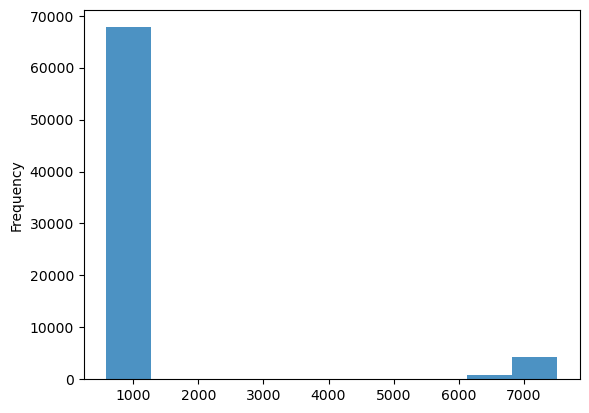

In [24]:
print(loans['Credit Score'].describe())
loans['Credit Score'].plot.hist(bins=10,alpha=0.8)

In [25]:
loans['Credit Score'] = np.where(loans['Credit Score'] > 800, loans['Credit Score']/10, loans['Credit Score'])

In [26]:
loans['Credit Score'].fillna(loans['Credit Score'].describe()['75%'],inplace=True)

### Years in current job Imputation

In [27]:
loans['Years in current job'].value_counts()

10+ years    27409
2 years       8187
< 1 year      7312
3 years       7262
5 years       6084
1 year        5765
4 years       5474
6 years       5095
7 years       4943
8 years       4098
9 years       3462
Name: Years in current job, dtype: int64

<AxesSubplot:ylabel='Frequency'>

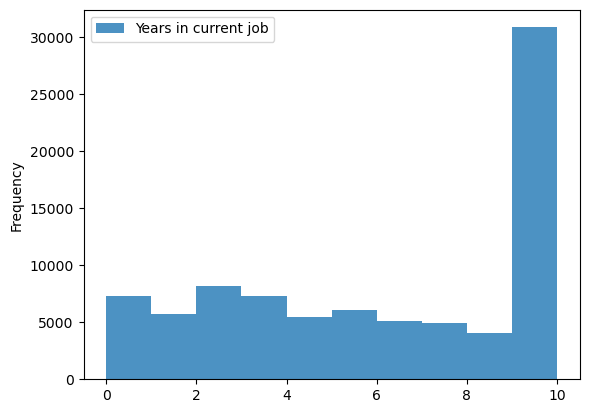

In [28]:
#Converting into numerical categories
years_dict = {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, 
              '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}
loans.replace({'Years in current job':years_dict},inplace=True)
loans[['Years in current job']].plot.hist(bins=10, alpha=0.8)

In [29]:
loans['Years in current job'].fillna(loans['Years in current job'].describe()['75%'],inplace=True)

#### Deliquency Imputation

In [30]:
loans['Months since last delinquent'].describe()

count    40402.000000
mean        35.080244
std         22.008115
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: Months since last delinquent, dtype: float64

In [31]:
loans['Months since last delinquent'].fillna(loans['Months since last delinquent'].describe()['75%'],inplace = True)

#### Term feature binarization

In [32]:
loans['Term'].value_counts()

Short Term    66931
Long Term     21977
Name: Term, dtype: int64

<AxesSubplot:ylabel='Frequency'>

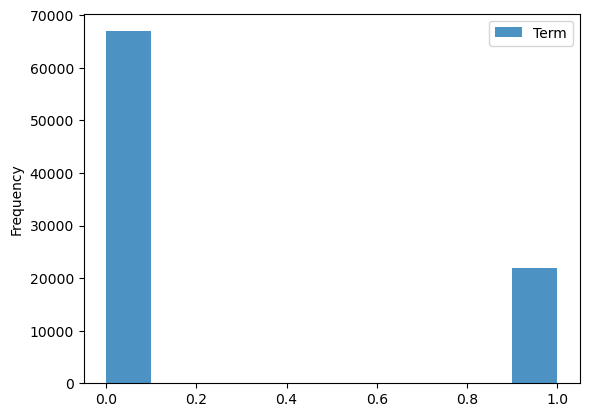

In [33]:
term_dict = {'Short Term':0,'Long Term':1}
loans.replace({'Term':term_dict},inplace=True)
loans[['Term']].plot.hist(bins=10,alpha=0.8)

In [34]:
loans['Term'].value_counts()

0    66931
1    21977
Name: Term, dtype: int64

#### Home ownership imputation

In [35]:
loans['Home Ownership'].value_counts()

Home Mortgage    43269
Rent             37394
Own Home          8075
HaveMortgage       170
Name: Home Ownership, dtype: int64

In [36]:
loans['Home Ownership'] = loans['Home Ownership'].str.replace('HaveMortgage','Home Mortgage',regex = True)

In [37]:
loans['Home Ownership'].value_counts()

Home Mortgage    43439
Rent             37394
Own Home          8075
Name: Home Ownership, dtype: int64

#### Purpose imputation

In [38]:
loans['Purpose'].value_counts()

Debt Consolidation      70446
Home Improvements        5205
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [39]:
loans['Purpose'] = loans['Purpose'].str.replace('Other','other',regex=True)

In [40]:
loans['Purpose'].value_counts()

Debt Consolidation      70446
other                    7767
Home Improvements        5205
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

#### Monthly debt imputation

In [41]:
loans['Monthly Debt'].describe()

count     88908
unique    70063
top           0
freq         69
Name: Monthly Debt, dtype: object

In [42]:
loans['Monthly Debt'] = loans['Monthly Debt'].str.replace('$','',regex=True)
loans['Monthly Debt'] = pd.to_numeric(loans['Monthly Debt'])

In [43]:
loans['Monthly Debt'].describe()

count    88908.000000
mean       963.094594
std        637.528906
min          0.000000
25%        532.217500
50%        843.880000
75%       1250.522500
max      22939.120000
Name: Monthly Debt, dtype: float64

#### years of credit history imputation

In [44]:
loans['Years of Credit History'].describe()

count    88908.000000
mean        18.315327
std          7.049218
min          3.600000
25%         13.500000
50%         17.000000
75%         21.800000
max         70.500000
Name: Years of Credit History, dtype: float64

- No Correction is required

#### Maximum open credit imputation

In [45]:
loans['Maximum Open Credit'].describe()

count     88908
unique    46625
top           0
freq        610
Name: Maximum Open Credit, dtype: object

In [46]:
loans['Maximum Open Credit'] = loans['Maximum Open Credit'].replace('#VALUE!',np.nan,regex=True)
loans['Maximum Open Credit'].fillna(loans['Maximum Open Credit'].median(),inplace=True)
loans['Maximum Open Credit'] = pd.to_numeric(loans['Maximum Open Credit'])

In [47]:
loans['Maximum Open Credit'].describe()

count    8.890800e+04
mean     3.596522e+04
std      4.041805e+05
min      0.000000e+00
25%      1.277500e+04
50%      2.178100e+04
75%      3.636700e+04
max      6.998809e+07
Name: Maximum Open Credit, dtype: float64

In [48]:
loans['Maximum Open Credit'].quantile([0.5,0.75,0.95,0.99,1])

0.50       21781.00
0.75       36367.00
0.95       76602.40
0.99      171423.93
1.00    69988086.00
Name: Maximum Open Credit, dtype: float64

In [49]:
loans.loc[loans['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423

#### Bankrupties Imputation

In [50]:
loans['Bankruptcies'].value_counts()

0.0    79321
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [51]:
loans['Bankruptcies'].fillna(loans['Bankruptcies'].median(),inplace = True)

#### TaxLien imputation

In [52]:
loans['Tax Liens'].value_counts()

0.0     87272
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
11.0        1
10.0        1
Name: Tax Liens, dtype: int64

In [53]:
loans['Tax Liens'].fillna(0.0,inplace = True)

In [54]:
loans['Tax Liens'].value_counts()

0.0     87280
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
11.0        1
10.0        1
Name: Tax Liens, dtype: int64

### Categorical Encoding

In [55]:
dummies = pd.get_dummies(loans['Purpose'], prefix='purpose')
loans[dummies.columns] = dummies

dummies = pd.get_dummies(loans['Home Ownership'], prefix='home')
loans[dummies.columns] = dummies

loans = loans.drop(["Home Ownership", "Purpose"], axis=1)

In [56]:
loans.isnull().any()

Loan ID                         False
Customer ID                     False
Loan Status                     False
Current Loan Amount             False
Term                            False
Credit Score                    False
Years in current job            False
Annual Income                   False
Monthly Debt                    False
Years of Credit History         False
Months since last delinquent    False
Number of Open Accounts         False
Number of Credit Problems       False
Current Credit Balance          False
Maximum Open Credit             False
Bankruptcies                    False
Tax Liens                       False
purpose_Business Loan           False
purpose_Buy House               False
purpose_Buy a Car               False
purpose_Debt Consolidation      False
purpose_Educational Expenses    False
purpose_Home Improvements       False
purpose_Medical Bills           False
purpose_Take a Trip             False
purpose_major_purchase          False
purpose_movi

#### Creating a new feature which directly effects customer affluence

In [57]:
loans['financial_propensity'] = loans['Annual Income']/(12*loans['Monthly Debt']+1)

In [58]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88908 entries, 0 to 88907
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan ID                       88908 non-null  object 
 1   Customer ID                   88908 non-null  object 
 2   Loan Status                   88908 non-null  object 
 3   Current Loan Amount           88908 non-null  float64
 4   Term                          88908 non-null  int64  
 5   Credit Score                  88908 non-null  float64
 6   Years in current job          88908 non-null  float64
 7   Annual Income                 88908 non-null  float64
 8   Monthly Debt                  88908 non-null  float64
 9   Years of Credit History       88908 non-null  float64
 10  Months since last delinquent  88908 non-null  float64
 11  Number of Open Accounts       88908 non-null  int64  
 12  Number of Credit Problems     88908 non-null  int64  
 13  C

In [59]:
loans.describe()

,Current Loan Amount,Term,Credit Score,Years in current job,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_Home Mortgage,home_Own Home,home_Rent,financial_propensity
count,88908.000000,88908.000000,88908.000000,88908.000000,8.890800e+04,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000,...,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000,88908.000000
mean,13803.877615,0.247188,723.839834,6.046857,7.240393e+04,963.094594,18.315327,43.765668,11.110271,0.160469,...,0.001395,0.087360,0.000101,0.002789,0.000922,0.001114,0.488584,0.090824,0.420592,58.779145
std,7914.421970,0.431379,26.431927,3.648671,5.223155e+04,637.528906,7.049218,16.820668,4.978486,0.473743,...,0.037320,0.282363,0.010061,0.052741,0.030356,0.033351,0.499872,0.287361,0.493657,2492.939860
min,491.000000,0.000000,585.000000,0.000000,4.033000e+03,0.000000,3.600000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.751667
25%,8066.000000,0.000000,714.000000,3.000000,4.879475e+04,532.217500,13.500000,36.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.464047
50%,12058.000000,0.000000,735.000000,6.000000,7.131500e+04,843.880000,17.000000,51.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.134701
75%,18194.500000,0.000000,741.000000,10.000000,7.997625e+04,1250.522500,21.800000,51.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,9.384255
max,35875.000000,1.000000,751.000000,10.000000,8.713547e+06,22939.120000,70.500000,176.000000,76.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,550368.000000


In [60]:
loans['Loan Status'].value_counts()

Loan Given      63737
Loan Refused    25171
Name: Loan Status, dtype: int64

#### Data Scaling/Normalization

In [61]:
final_loans = loans

In [62]:
y = LabelBinarizer().fit_transform(final_loans['Loan Status']).ravel()
column_names_to_standardize = list(final_loans.columns[3:])
data_scaled = StandardScaler().fit_transform(final_loans[column_names_to_standardize].values)

data_temp = pd.DataFrame(data_scaled, columns=column_names_to_standardize, index = final_loans.index)
final_loans[column_names_to_standardize] = data_temp

In [63]:
final_loans.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Annual Income,Monthly Debt,Years of Credit History,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_Home Mortgage,home_Own Home,home_Rent,financial_propensity
0,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Loan Given,-0.261913,-0.573021,0.838391,-0.560990,-0.428459,-0.953554,-0.966826,...,-0.037372,-0.30939,-0.010062,-0.052889,-0.030383,-0.033388,-0.977422,-0.316065,1.173712,-0.018871
1,0000afa6-8902-4f8f-b870-25a8fdad0aeb,e49c1a82-a0f7-45e8-9f46-2f75c43f9fbc,Loan Refused,1.365758,1.745137,0.649225,-0.012842,0.000000,-0.660059,-0.101477,...,-0.037372,-0.30939,-0.010062,-0.052889,-0.030383,-0.033388,-0.977422,-0.316065,1.173712,-0.019116
2,00020fb0-6b8a-4b3a-8c72-9c4c847e8cb6,c9decd06-16f7-44c3-b007-8776f2a9233d,Loan Given,-0.220596,-0.573021,0.687058,-0.835064,-0.146348,-0.596454,1.203640,...,-0.037372,-0.30939,-0.010062,-0.052889,-0.030383,-0.033388,1.023099,-0.316065,-0.851998,-0.019865
3,00045ecd-59e9-4752-ba0d-679ff71692b3,b7bce684-b4b0-4b29-af66-eae316bce573,Loan Given,-0.245234,-0.573021,0.384392,1.083453,-0.061303,-0.162871,1.700152,...,-0.037372,-0.30939,-0.010062,-0.052889,-0.030383,-0.033388,-0.977422,3.163902,-0.851998,-0.020886
4,0004f37b-5859-40f6-98d0-367aa3b3f3f1,f662b062-5fa5-463d-b5c0-4e36d09fcab1,Loan Given,-0.010724,-0.573021,0.006060,-1.383212,-0.729581,-0.291305,-0.668919,...,-0.037372,-0.30939,-0.010062,-0.052889,-0.030383,-0.033388,-0.977422,3.163902,-0.851998,-0.022104


In [64]:
final_loans.to_csv('final_loans.csv',index=False)

### Model Training

In [65]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprl9kmxzv
  JVM stdout: /tmp/tmprl9kmxzv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprl9kmxzv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_gtkkza
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [66]:
hf = h2o.H2OFrame(final_loans)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [67]:
predictors = list(final_loans.columns[3:])
response = 'Loan Status'

In [68]:
train,test=hf.split_frame(ratios=[.8],seed=1234)

In [69]:
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [5, 9],
                'ntrees': [300, 500],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.5, 1.0]}

In [70]:
gbm_grid1 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                         grid_id = 'gbm_grid1',
                         hyper_params = gbm_params1)

In [71]:
gbm_grid1.train(x=predictors, y=response, training_frame=train, seed =1234)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,logloss
,1.0,0.1,9.0,500.0,0.8,gbm_grid1_model_16,0.4022992
,1.0,0.1,9.0,300.0,0.8,gbm_grid1_model_8,0.4022992
,1.0,0.1,9.0,300.0,1.0,gbm_grid1_model_24,0.4069305
,1.0,0.1,9.0,500.0,1.0,gbm_grid1_model_32,0.4069305
,0.5,0.1,9.0,500.0,0.8,gbm_grid1_model_15,0.4113870
,0.5,0.1,9.0,300.0,0.8,gbm_grid1_model_7,0.4113870
,0.5,0.1,9.0,300.0,1.0,gbm_grid1_model_23,0.4170401
,0.5,0.1,9.0,500.0,1.0,gbm_grid1_model_31,0.4170401
,1.0,0.01,9.0,500.0,1.0,gbm_grid1_model_30,0.4551417
,1.0,0.01,9.0,500.0,0.8,gbm_grid1_model_14,0.4571701


In [73]:
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='aucpr',decreasing=True)
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,1.0,0.1,9.0,500.0,0.8,gbm_grid1_model_16,0.8069838
,1.0,0.1,9.0,300.0,0.8,gbm_grid1_model_8,0.8069838
,1.0,0.1,9.0,300.0,1.0,gbm_grid1_model_24,0.8010482
,1.0,0.1,9.0,500.0,1.0,gbm_grid1_model_32,0.8010482
,0.5,0.1,9.0,500.0,0.8,gbm_grid1_model_15,0.7854780
,0.5,0.1,9.0,300.0,0.8,gbm_grid1_model_7,0.7854780
,0.5,0.1,9.0,300.0,1.0,gbm_grid1_model_23,0.7796033
,0.5,0.1,9.0,500.0,1.0,gbm_grid1_model_31,0.7796033
,1.0,0.01,9.0,500.0,1.0,gbm_grid1_model_30,0.7081828
,1.0,0.01,9.0,500.0,0.8,gbm_grid1_model_14,0.7049802


#### Picking up the best model from the gridsearch

In [75]:
best_gbm1 = gbm_gridperf1.models[0]
perf = best_gbm1.model_performance(test)
print(perf)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1767553950068158
RMSE: 0.4204228764075711
LogLoss: 0.5218376892713833
Mean Per-Class Error: 0.3604157665289251
AUC: 0.710970390102987
AUCPR: 0.489123395071786
Gini: 0.42194078020597403

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22111748178615867
              Loan Given    Loan Refused    Error    Rate
------------  ------------  --------------  -------  ----------------
Loan Given    5965          6923            0.5372   (6923.0/12888.0)
Loan Refused  904           4018            0.1837   (904.0/4922.0)
Total         6869          10941           0.4395   (7827.0/17810.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.221117     0.506588  280
max f2                       0.100972     0.69462   352
max f0point5                 0.384944     0.463274 

In [77]:
train.shape,test.shape

((71098, 36), (17810, 36))

In [80]:
gbm = H2OGradientBoostingEstimator(col_sample_rate=1.0,max_depth=9,ntrees=500,seed=1234)
gbm.train(x=predictors, y=response, training_frame=train)
perf = gbm.model_performance(test)
print(perf)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.17621692109042147
RMSE: 0.4197819923370004
LogLoss: 0.5204555151310172
Mean Per-Class Error: 0.35228320332254554
AUC: 0.7132856042783878
AUCPR: 0.48934611730199407
Gini: 0.42657120855677566

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24787945758479724
              Loan Given    Loan Refused    Error    Rate
------------  ------------  --------------  -------  ----------------
Loan Given    6824          6064            0.4705   (6064.0/12888.0)
Loan Refused  1152          3770            0.2341   (1152.0/4922.0)
Total         7976          9834            0.4052   (7216.0/17810.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.247879     0.510979  261
max f2

In [82]:
model_path = h2o.save_model(
  gbm,
  path = "my_model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'/kaggle/working/my_model/GBM_model_python_1678126724286_1104'

In [84]:
h2o.load_model('/kaggle/working/my_model/GBM_model_python_1678126724286_1104')

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1678126724286_1104


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    129                129                         323582                 0            9            8.83721       1             381           195.147

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12912879285121429
RMSE: 0.35934494966704944
LogLoss: 0.4069304648219124
Mean Per-Class Error: 0.19977049514542589
AUC: 0.8973938495505388
AUCPR: 0.8010482058372541
Gini: 0.7947876991010776

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.356785589325814
              Loan Given    Loan Refused    Error    Rate
------------  ------------  --------------  -------  -----------------
Loan Given    44510         6339            0.1247   (6339.0/50849.0)
Loan Refused  5566          14683           0.2749   (5566.0/20249.0)
Total         50076         21022           0.1674   (11905.0/71098.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.356786     0.711541  195
max f2                       0.255132     0.79124   257
max f0point5                 0.449357     0.751948  148
max accuracy                 0.402215     0.841894  170
max precision                0.978946     1         0
max recall                   0.0498833    1         374
max specificity              0.978946     1         0
max absolute_mcc             0.374635     0.597319  185
max min_per_class_accuracy   0.319235     0.805768  218
max mean_per_class_accuracy  0.323844     0.807622  215
max tns                      0.978946     50849     0
max fns                      0.978946     20241     0
max fps                      0.00330782   50849     399
max tps                      0.0498833    20249     374
max tnr                      0.978946     1         0
max fnr                      0.978946     0.999605  0
max fpr                      0.00330782   1         399
max tpr                      0.0498833    1         374

Gains/Lift Table: Avg response rate: 28.48 %, avg score: 28.49 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100003                   0.853974           3.49637    3.49637            0.995781         0.897926   0.995781                    0.897926            0.0349647       0.0349647                  249.637   249.637            0.0349057
2        0.0200006                   0.792486           3.42723    3.4618             0.97609          0.821156   0.985935                    0.859541            0.0342733       0.069238                   242.723   246.18             0.0688447
3        0.0300008                   0.741542           3.30871    3.41077            0.942335         0.76689    0.971402                    0.828657            0.0330881       0.102326                   230.871   241.077            0.101126
4        0.0400011                   0.697879           3.27414    3.37661            0.932489         0.718485   0.961674                    0.801114            0.0327424       0.135068                   227.414   237.661            0.132925
5

In [87]:
xgb = H2OXGBoostEstimator(ntrees=200, seed=1234)
xgb.train(x=predictors, y=response, training_frame=train)

perf = xgb.model_performance(test)
print(perf)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.17995842549409563
RMSE: 0.42421506985737273
LogLoss: 0.5311201500515561
Mean Per-Class Error: 0.3596572388982592
AUC: 0.7035863915316051
AUCPR: 0.4758569241878107
Gini: 0.40717278306321014

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.259810165218685
              Loan Given    Loan Refused    Error    Rate
------------  ------------  --------------  -------  ----------------
Loan Given    7354          5534            0.4294   (5534.0/12888.0)
Loan Refused  1427          3495            0.2899   (1427.0/4922.0)
Total         8781          9029            0.3908   (6961.0/17810.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25981      0.501039  255
max f

In [88]:
dnn = H2ODeepLearningEstimator(hidden=[16,16],epochs=100, balance_classes=True)
dnn.train(x=predictors, y=response, training_frame=train)
perf=dnn.model_performance(test)
print(perf)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18428480306975917
RMSE: 0.4292840587184192
LogLoss: 0.5490896607987287
Mean Per-Class Error: 0.3633533368846999
AUC: 0.6942511355292784
AUCPR: 0.45840779935220005
Gini: 0.38850227105855684

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29723172520053215
              Loan Given    Loan Refused    Error    Rate
------------  ------------  --------------  -------  ----------------
Loan Given    6701          6187            0.4801   (6187.0/12888.0)
Loan Refused  1214          3708            0.2466   (1214.0/4922.0)
Total         7915          9895            0.4156   (7401.0/17810.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.297232     0.500506  24

In [90]:
lgbm = H2OXGBoostEstimator(ntrees=200,seed=1234, tree_method='hist',grow_policy='lossguide' )
lgbm.train(x=predictors, y=response, training_frame=train)
perf = lgbm.model_performance(test)
print(perf)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18017953966751726
RMSE: 0.42447560550344615
LogLoss: 0.5330175750504696
Mean Per-Class Error: 0.3655818635392445
AUC: 0.7016955505261344
AUCPR: 0.47967827554090703
Gini: 0.40339110105226883

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21669595887263615
              Loan Given    Loan Refused    Error    Rate
------------  ------------  --------------  -------  ----------------
Loan Given    6167          6721            0.5215   (6721.0/12888.0)
Loan Refused  1032          3890            0.2097   (1032.0/4922.0)
Total         7199          10611           0.4353   (7753.0/17810.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.216696     0.500869  279
ma

- Observing the AUC and AUCPR, Gradient Boosting model outperforms and should be selected for inference